In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBClassifier, XGBRegressor, XGBRFRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

SEED = 314159
TRAIN_TEST_SPLIT = 0.80

data_path = r"C:\Users\nikol_ri8fhbe\Documents\ml"

In [2]:
X, y = make_classification(n_samples=1000, n_features=20, n_informative=15,
                           n_redundant=5, random_state=42)

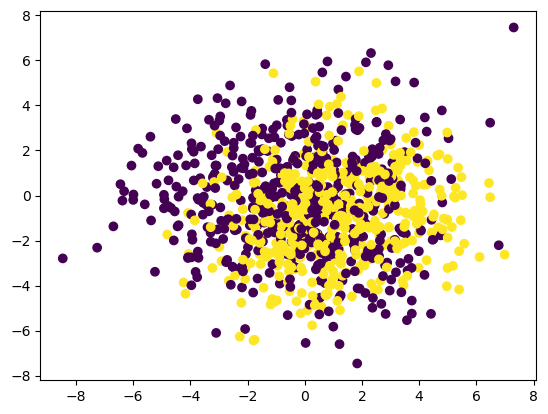

In [3]:
plt.scatter(X[:, 2], X[:, 3], c=y)

# Ансамбли: бустинги


Бустинг строится последовательно: каждое следующее дерево в нем обучается на основе результатов предыдущего, пытаясь уменьшить его ошибку. Как следствие, композиция будет иметь меньшее смещение, чем исходные базовые модели. Поэтому логично в качестве базовых моделей использовать те, которые изначально обладают небольшим разбросом и высоким смещением. Вопрос: какие это будут модели?
Еще одно соображение для выбора сильно смещенных моделей в том, что они банально быстрее учатся. Так как невозможно распараллелить обучение базовых моделей, то скорость их настройки становится серьезным вопросом. 

Что интересно, бустинги не очень хорошо работают с однородными данными - поэтому их нечасто применяют для текстов.

Расссмотрим квадратичную функцию потерь и композицию следующего вида: $ a = b_1 +  b_2 + ... + b_N $
Обучим только одно дерево $ a = b_1 $. Найдем примеры, для которых оно ошибается в  предсказании. Обучим для них еще одно дерево - $ b_2 $, которое будет предсказывать ошибку первого. Будем повторять это, пока не наберем K деревьев. Примерно так на верхнем уровне обучается бустинг. 


In [4]:
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold


def eval_classifier(clf):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=43)
    n_scores = cross_val_score(clf, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    return np.mean(n_scores), np.std(n_scores)

In [5]:
results_accuracy = pd.DataFrame(0.0,
                                columns=["W/o ensembling", 'Bagging', "Bagging_with_mf", 'AdaBoost'],
                                index=['deep DTC', '1-level DTC', 'LR', 'SVC'])

In [6]:
acc_mean, acc_std = eval_classifier(DecisionTreeClassifier())

results_accuracy.loc['deep DTC', 'W/o ensembling'] = acc_mean
print(f"{acc_mean:.2f}, +- {acc_std:.2f}")

0.79, +- 0.05


In [7]:
acc_mean, acc_std = eval_classifier(DecisionTreeClassifier(max_depth=1))

results_accuracy.loc['1-level DTC', 'W/o ensembling'] = acc_mean
print(f"{acc_mean:.2f} +- {acc_std:.2f}")

0.68 +- 0.04


In [8]:
from sklearn.ensemble import BaggingClassifier

In [9]:
acc_mean, acc_std = eval_classifier(
    BaggingClassifier(DecisionTreeClassifier(), n_estimators=10,
                      max_samples=1.0, max_features=1.0,
                      bootstrap=True, bootstrap_features=False))

results_accuracy.loc['deep DTC', 'Bagging'] = acc_mean
print(f"{acc_mean:.2f}, {acc_std:.2f}")

0.86, 0.03


In [10]:
acc_mean, acc_std = eval_classifier(
    BaggingClassifier(DecisionTreeClassifier(max_depth=1), n_estimators=10,
                      max_samples=1.0, max_features=1.0,
                      bootstrap=True, bootstrap_features=False))

results_accuracy.loc['1-level DTC', 'Bagging'] = acc_mean
print(f"{acc_mean:.2f}, {acc_std:.2f}")

0.69, 0.04


In [11]:
acc_mean, acc_std = eval_classifier(
    BaggingClassifier(DecisionTreeClassifier(), n_estimators=10,
                      max_samples=1.0, max_features=0.8,
                      bootstrap=True, bootstrap_features=False))

results_accuracy.loc['deep DTC', 'Bagging_with_mf'] = acc_mean
print(f"{acc_mean:.2f}, {acc_std:.2f}")

0.87, 0.03


In [12]:
acc_mean, acc_std = eval_classifier(
    BaggingClassifier(DecisionTreeClassifier(max_depth=1), n_estimators=10,
                      max_samples=1.0, max_features=0.8,
                      bootstrap=True, bootstrap_features=False))

results_accuracy.loc['1-level DTC', 'Bagging_with_mf'] = acc_mean
print(f"{acc_mean:.2f}, {acc_std:.2f}")

0.69, 0.04


In [13]:
results_accuracy

,W/o ensembling,Bagging,Bagging_with_mf,AdaBoost
deep DTC,0.787333,0.857000,0.867333,0.0
1-level DTC,0.683333,0.687333,0.688333,0.0
LR,0.000000,0.000000,0.000000,0.0
SVC,0.000000,0.000000,0.000000,0.0


**Задание**: Дополните таблицу: обучите также логистическую регрессию с беггингом и без него.

In [14]:
acc_mean, acc_std = eval_classifier(LogisticRegression(max_iter=1000))
results_accuracy.loc['LR', 'W/o ensembling'] = acc_mean
print(f"LR without bagging: {acc_mean:.2f}, +- {acc_std:.2f}")

LR without bagging: 0.81, +- 0.03


In [15]:
bagging_lr = BaggingClassifier(
    estimator=LogisticRegression(max_iter=1000),
    n_estimators=10,
    random_state=42
)
acc_mean, acc_std = eval_classifier(bagging_lr)
results_accuracy.loc['LR', 'Bagging'] = acc_mean
print(f"LR with bagging: {acc_mean:.2f}, +- {acc_std:.2f}")

LR with bagging: 0.81, +- 0.03


In [16]:
results_accuracy

,W/o ensembling,Bagging,Bagging_with_mf,AdaBoost
deep DTC,0.787333,0.857000,0.867333,0.0
1-level DTC,0.683333,0.687333,0.688333,0.0
LR,0.811333,0.812333,0.000000,0.0
SVC,0.000000,0.000000,0.000000,0.0


## AdaBoost

AdaBoost обучает каждый следующий классификатор на объектах, на которых ошибаются предыдущие (объекты с ошибками получают больший вес, без ошибок — меньший).

In [17]:
from sklearn.ensemble import AdaBoostClassifier

In [18]:
acc_mean, acc_std = eval_classifier(
    AdaBoostClassifier(DecisionTreeClassifier(), n_estimators=50, learning_rate=1.0))

results_accuracy.loc['deep DTC', 'AdaBoost'] = acc_mean
print(f"{acc_mean:.2f}, {acc_std:.2f}")

0.79, 0.04


In [19]:
acc_mean, acc_std = eval_classifier(
    AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), n_estimators=50, learning_rate=1.0))

results_accuracy.loc['1-level DTC', 'AdaBoost'] = acc_mean
print(f"{acc_mean:.2f}, {acc_std:.2f}")

0.82, 0.04


In [20]:
def highlight_max(s, props=''):
    return np.where(s == np.nanmax(s.values), props, '')


results_to_show = results_accuracy.copy()

results_to_show.style.apply(highlight_max, props='font-weight: bold;', axis=1).format('{:.3f}')

,W/o ensembling,Bagging,Bagging_with_mf,AdaBoost
deep DTC,0.787,0.857,0.867,0.787
1-level DTC,0.683,0.687,0.688,0.818
LR,0.811,0.812,0.000,0.000
SVC,0.000,0.000,0.000,0.000


**Задание:** выясните, дадут ли улучшение бэггинг и бустинг над линейной регрессией. Объясните, почему так.

In [21]:
acc_mean, acc_std = eval_classifier(
    AdaBoostClassifier(LogisticRegression(max_iter=1000), n_estimators=50, learning_rate=1.0)
)
results_accuracy.loc['LR', 'AdaBoost'] = acc_mean
print(f"LR with AdaBoost: {acc_mean:.2f}, +- {acc_std:.2f}")

LR with AdaBoost: 0.82, +- 0.04


In [22]:
results_to_show = results_accuracy.copy()
results_to_show.style.apply(highlight_max, props='font-weight: bold;', axis=1).format('{:.3f}')

,W/o ensembling,Bagging,Bagging_with_mf,AdaBoost
deep DTC,0.787,0.857,0.867,0.787
1-level DTC,0.683,0.687,0.688,0.818
LR,0.811,0.812,0.000,0.815
SVC,0.000,0.000,0.000,0.000


Вопрос: Почему AdaBoost хуже работает на глубоких деревьях?

# Градиентный бустинг

Рассмотрим композицию $a = \sum_{i} {\gamma_i b_i}$. Для начала выбирается какой-нибудь простой $\gamma_0, b_0$ (например, 0 и среднее). Формально каждая N-ая модель, начиная со второй, пытается приблизиить антиградиент функционала ошибки, взятый в точках ${z_i=a_{N-1}(x_i)}$:
$$s_i = -\dfrac{\partial L(y, z)}{\partial z}|_{z=a_{N-1}}$$
Подбор алгоритма при этом производится, приближая эту ошибку c точки зрения квадратичной функции потерь.
$$ b_i = arg \min_{b \in \mathcal{B}} {\sum (b_i(x) - s_i)^2} $$

Градиентный бустинг - довольно мощная метамодель, с огромным количеством параметров и хитростей. Мы сегодня остановимся только на основных. Для начала рассмотрим самый стандартный бустинг с использованием деревьев решений (CART). Параметры базовых моделей такие же, как и раньше, но настройка амого бустинга довольно сложна!

Важный вопрос при обучении модели - какую функцию ошибок выбрать? Какая задача возникает при обработке датасета с вином?

Для того, чтобы оценивать модель, полезны различные метрики - численные характеристики ее качества. При этом бустинги настолько галантны, что предоставляют нам возможность оценивать метрики прямо при обучении. Для этого необходимо задать тип метрики в конструкторе и eval_set при запуске fit().

На практике обычно используется один из трех вариантов бустинга - Xgboost, LightGBM или CatBoost.

### [XGBoost](https://www.kdd.org/kdd2016/papers/files/rfp0697-chenAemb.pdf).
Плюсы:
- Позволяет легко паралелить вычисления (например на спарке)
- Легко использовать с sklearn и numpy (но с потерей производительности)
- Поддерживается обработка разреженных данных
- Предсортированные блоки, кэши, шардирование

Минусы:
- Нет поддержки GPU

[документация](https://xgboost.readthedocs.io/en/latest/)

  
### [LightGBM](https://papers.nips.cc/paper/2017/file/6449f44a102fde848669bdd9eb6b76fa-Paper.pdf)
Плюсы:
- Поддержка GPU
- Метод Фишера для работы с категориальными признаками
- Уменьшение размера обучающей выборки (GOSS)
- Объединение разреженных признаков (EFB)

Минусы:
- Итерфейс не совместим с sklearn/numpy

[документация](https://lightgbm.readthedocs.io/en/latest/Python-API.html)

### [CatBoost](https://papers.nips.cc/paper/2017/file/6449f44a102fde848669bdd9eb6b76fa-Paper.pdf)
Плюсы:
- Поддержка GPU
- Легко использовать с sklearn и numpy
- Более продвинутая работа с категориальными фичами
- Наши слоны
  
Минусы:
- Бывает работает хуже (возможно слабее эвристики), но с категориальными фичами — хорошо

[документация](https://catboost.ai/docs/concepts/python-quickstart.html)


In [23]:
from catboost import CatBoostClassifier

acc_mean, acc_std = eval_classifier(
    CatBoostClassifier(
        iterations=10,
        depth=1,
        learning_rate=1,
        loss_function='Logloss',
        verbose=True,
        task_type='CPU'))

сat_boost = acc_mean

results_accuracy.loc['1-level DTC', 'CatBoost'] = acc_mean
print(f"{acc_mean:.2f}, {acc_std:.2f}")

0.76, 0.04


In [24]:
from catboost import CatBoostClassifier

acc_mean, acc_std = eval_classifier(
    CatBoostClassifier(
        iterations=10,
        learning_rate=1,
        loss_function='Logloss',
        verbose=True,
        task_type='CPU'))

сat_boost = acc_mean

results_accuracy.loc['deep DTC', 'CatBoost'] = acc_mean
print(f"{acc_mean:.2f}, {acc_std:.2f}")

0.86, 0.03


In [25]:
from xgboost import XGBClassifier

acc_mean, acc_std = eval_classifier(XGBClassifier(objective='binary:logistic', random_state=42))

xg_boost = acc_mean
print(f"{acc_mean:.2f}, {acc_std:.2f}")

results_accuracy.loc['deep DTC', 'XGBoost'] = acc_mean

0.92, 0.03


In [26]:
acc_mean, acc_std = eval_classifier(XGBClassifier(objective='binary:logistic', max_depth=1, random_state=42))

xg_boost = acc_mean
print(f"{acc_mean:.2f}, {acc_std:.2f}")

results_accuracy.loc['1-level DTC', 'XGBoost'] = acc_mean

0.84, 0.03


In [27]:
results_to_show = results_accuracy.copy()
results_to_show.style.apply(highlight_max, props='font-weight: bold;', axis=1).format('{:.3f}')

,W/o ensembling,Bagging,Bagging_with_mf,AdaBoost,CatBoost,XGBoost
deep DTC,0.787,0.857,0.867,0.787,0.862,0.920
1-level DTC,0.683,0.687,0.688,0.818,0.759,0.841
LR,0.811,0.812,0.000,0.815,nan,nan
SVC,0.000,0.000,0.000,0.000,nan,nan


In [28]:
import lightgbm as lgb

train_data = lgb.Dataset(X, label=y)

param = {'num_leaves': 31,
         'objective': 'multiclass',
         'num_class': 2,
         'metric': ['multi_logloss']}

num_round = 10
boost = lgb.train(param, train_data, num_boost_round=10)

lg_boost = (boost.predict(X).argmax(axis=-1) == y).mean()

results_accuracy.loc['deep DTC', 'LightGBM'] = lg_boost
print(f"{lg_boost:.2f}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001494 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 20
[LightGBM] [Info] Start training from score -0.689155
[LightGBM] [Info] Start training from score -0.697155
0.95


In [29]:
results_to_show = results_accuracy.copy()

results_to_show.style.apply(highlight_max, props='font-weight: bold;', axis=1).format('{:.3f}')

,W/o ensembling,Bagging,Bagging_with_mf,AdaBoost,CatBoost,XGBoost,LightGBM
deep DTC,0.787,0.857,0.867,0.787,0.862,0.920,0.947
1-level DTC,0.683,0.687,0.688,0.818,0.759,0.841,nan
LR,0.811,0.812,0.000,0.815,nan,nan,nan
SVC,0.000,0.000,0.000,0.000,nan,nan,nan


## Пример
Рассмотрим реальный датасет, и на его примере попробуем поработать с бустингом.

In [31]:

from sklearn import datasets

ds = datasets.load_diabetes()
X = ds.data
Y = ds.target
X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=0.5, test_size=0.5)


In [32]:
model = XGBRegressor(n_estimators=100, learning_rate=1, seed=SEED)
fit_params = {"eval_set": [(X_train, y_train), (X_test, y_test)], "verbose": False}
# Add verbose=False to avoid printing out updates with each cycle
model.fit(X_train, y_train,
          eval_set=[(X_train, y_train), (X_test, y_test)],
          verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [33]:
results = model.evals_result()

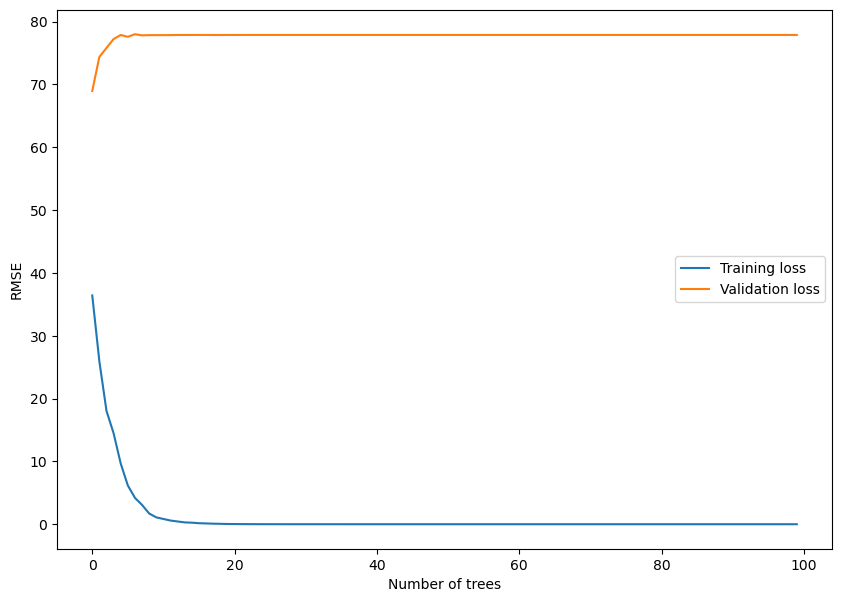

In [34]:
error_function = "rmse"
plt.figure(figsize=(10, 7))
plt.plot(results["validation_0"][error_function], label="Training loss")
plt.plot(results["validation_1"][error_function], label="Validation loss")
plt.xlabel("Number of trees")
plt.ylabel("RMSE")
plt.legend()

Как мы видим, хотя лосс при обучении падал и падал, на валидации метрики перестали улучшаться довольно рано. Это довольно плохой знак. Однако говорит ли это о катастрофической ситуации? Проверим переобучение с помощью кросс-валидации.

In [35]:
from sklearn.model_selection import cross_validate

cv_results = cross_validate(model, X, Y, cv=10, scoring=["neg_root_mean_squared_error"],
                            return_train_score=True)
print("Train RMSE is", -cv_results['train_neg_root_mean_squared_error'].mean())
print("Test RMSE is", -cv_results['test_neg_root_mean_squared_error'].mean())


Train RMSE is 0.0006158542364544242
Test RMSE is 74.76829897433832


Кажется, у нас действительно серьезные проблемы. Попробуем уменьшить скорость обучения.


In [36]:
# train and eval model with smaller lr
model = XGBRegressor(n_estimators=100, learning_rate=0.01, seed=SEED)
fit_params = {"eval_set": [(X_train, y_train), (X_test, y_test)], "verbose": False}
# Add verbose=False to avoid printing out updates with each cycle
model.fit(X_train, y_train,
          eval_set=[(X_train, y_train), (X_test, y_test)],
          verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

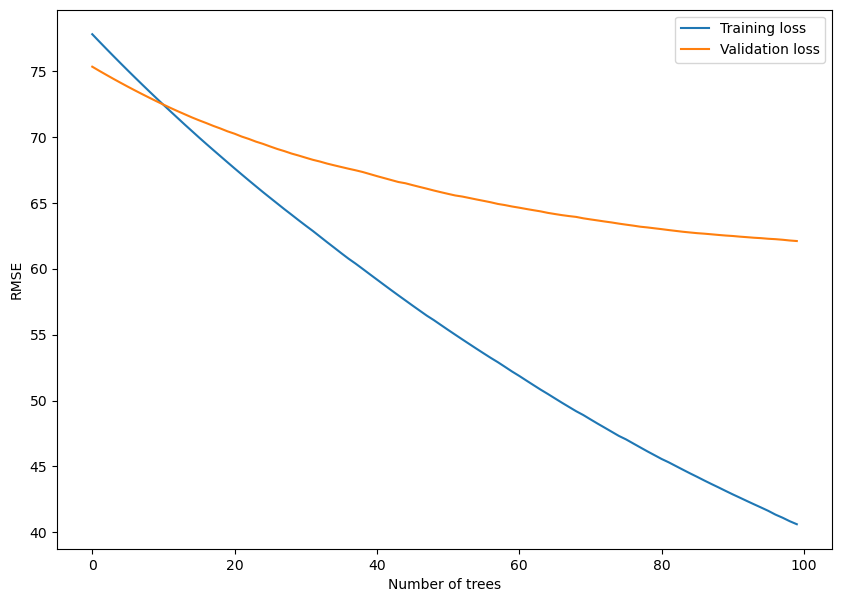

In [37]:
# plot results
results = model.evals_result()
error_function = "rmse"
plt.figure(figsize=(10, 7))
plt.plot(results["validation_0"][error_function], label="Training loss")
plt.plot(results["validation_1"][error_function], label="Validation loss")
plt.xlabel("Number of trees")
plt.ylabel("RMSE")
plt.legend()

Помогло ли это? Попробуем получить результаты лучше, поиграв с параметрами.

In [38]:
from sklearn.model_selection import cross_validate

cv_results = cross_validate(model, X, Y, cv=10, scoring=["neg_root_mean_squared_error"],
                            return_train_score=True)
print("Train RMSE is", -cv_results['train_neg_root_mean_squared_error'].mean())
print("Test RMSE is", -cv_results['test_neg_root_mean_squared_error'].mean())


Train RMSE is 43.73849456394957
Test RMSE is 63.41708797396801


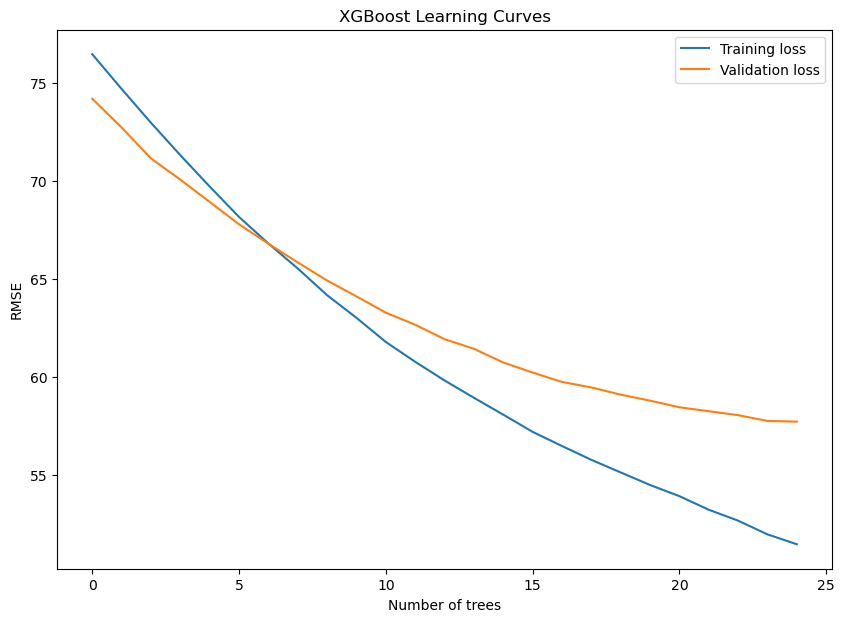


Cross-Validation Results:
Train RMSE: 53.101
Test RMSE: 59.065


In [51]:
from sklearn.model_selection import cross_validate

model = XGBRegressor(
    n_estimators=25,
    max_depth=3,
    learning_rate=0.05,
    reg_alpha=1.0,
    reg_lambda=2.0,
    subsample=0.7,
    random_state=42
)

model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],

    verbose=False
)

results = model.evals_result()
plt.figure(figsize=(10, 7))
plt.plot(results["validation_0"]["rmse"], label="Training loss")
plt.plot(results["validation_1"]["rmse"], label="Validation loss")
plt.xlabel("Number of trees")
plt.ylabel("RMSE")
plt.title("XGBoost Learning Curves")
plt.legend()
plt.show()

cv_results = cross_validate(
    model, X, Y, cv=10,
    scoring=["neg_root_mean_squared_error"],
    return_train_score=True
)

print("\nCross-Validation Results:")
print(f"Train RMSE: {-cv_results['train_neg_root_mean_squared_error'].mean():.3f}")
print(f"Test RMSE: {-cv_results['test_neg_root_mean_squared_error'].mean():.3f}")

In [ ]:
# your code

Так как параметров довольно много, может быть разумно автоматизировать их поиск. Для этого воспользуемся поиском по решетке.

In [57]:
from sklearn.model_selection import GridSearchCV

fit_params = {}
model = XGBRegressor(random_state=42)

xgboost_params = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8],
    'colsample_bytree': [0.8],
    'reg_alpha': [0, 0.1],
    'reg_lambda': [1.0],
    'gamma': [0]
}

xgboost_best_grid = GridSearchCV(
    model,
    xgboost_params,
    cv=5,
    n_jobs=-1,
    scoring='neg_root_mean_squared_error',
    verbose=1
).fit(X_train, y_train, **fit_params)

print("Лучшие параметры:", xgboost_best_grid.best_params_)


Fitting 5 folds for each of 16 candidates, totalling 80 fits
Лучшие параметры: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'reg_alpha': 0, 'reg_lambda': 1.0, 'subsample': 0.8}


In [58]:
print(xgboost_best_grid.best_params_)

{'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'reg_alpha': 0, 'reg_lambda': 1.0, 'subsample': 0.8}


Давайте проверим, какую точность мы получим с лучшими параметрами.

In [59]:
from sklearn.metrics import mean_squared_error, r2_score

best_model = xgboost_best_grid.best_estimator_

y_pred = best_model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Лучшие параметры: {xgboost_best_grid.best_params_}")
print(f"Test RMSE: {rmse:.3f}")
print(f"R² Score: {r2:.3f}")

Лучшие параметры: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'reg_alpha': 0, 'reg_lambda': 1.0, 'subsample': 0.8}
Test RMSE: 55.832
R² Score: 0.455


**Задание:** Проведите обучение и с LightGBM/CatBoost. Какие лучшие точности у вас получилось получить?

In [60]:
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

In [61]:
SEED = 42
N_ITER = 30  
CV = 5       

In [62]:
lgbm = LGBMRegressor(random_state=SEED, verbose=-1)

lgbm_params = {
    'n_estimators': randint(50, 200),
    'max_depth': randint(3, 8),
    'learning_rate': uniform(0.01, 0.3),
    'num_leaves': randint(20, 50),
    'min_child_samples': randint(10, 30),
    'reg_alpha': uniform(0, 1),
    'reg_lambda': uniform(0, 1)
}

lgbm_search = RandomizedSearchCV(
    lgbm, lgbm_params,
    n_iter=N_ITER, cv=CV,
    scoring='neg_root_mean_squared_error',
    random_state=SEED, n_jobs=-1
).fit(X_train, y_train)

best_lgbm = lgbm_search.best_estimator_
lgbm_rmse = np.sqrt(-lgbm_search.best_score_)

C:\Users\2005k\miniconda3\envs\spbu-ai-fundamentals1\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\2005k\miniconda3\envs\spbu-ai-fundamentals1\lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


In [63]:
cat = CatBoostRegressor(random_state=SEED, verbose=0)

cat_params = {
    'iterations': randint(50, 200),
    'depth': randint(3, 8),
    'learning_rate': uniform(0.01, 0.3),
    'l2_leaf_reg': uniform(0, 5),
    'border_count': [32, 64, 128],
    'grow_policy': ['SymmetricTree', 'Depthwise']
}


cat_search = RandomizedSearchCV(
    cat, cat_params,
    n_iter=N_ITER, cv=CV,
    scoring='neg_root_mean_squared_error',
    random_state=SEED, n_jobs=-1
).fit(X_train, y_train)


best_cat = cat_search.best_estimator_
cat_rmse = np.sqrt(-cat_search.best_score_)

In [64]:
results = {
    'XGBoost': np.sqrt(-xgboost_best_grid.best_score_),
    'LightGBM': lgbm_rmse,
    'CatBoost': cat_rmse
}

print("Средний RMSE на кросс-валидации:")
for model, rmse in sorted(results.items(), key=lambda x: x[1]):
    print(f"{model}: {rmse:.3f}")

Средний RMSE на кросс-валидации:
LightGBM: 7.599
CatBoost: 7.618
XGBoost: 7.768


In [65]:
best_model_name = min(results, key=results.get)
best_model = {
    'XGBoost': xgboost_best_grid.best_estimator_,
    'LightGBM': best_lgbm,
    'CatBoost': best_cat
}[best_model_name]

final_pred = best_model.predict(X_test)
final_rmse = np.sqrt(mean_squared_error(y_test, final_pred))

print(f"\nЛучшая модель: {best_model_name}")
print(f"Test RMSE: {final_rmse:.3f}")
print(f"R2 Score: {r2_score(y_test, final_pred):.3f}")


Лучшая модель: LightGBM
Test RMSE: 58.007
R2 Score: 0.412


**Задание:** Постройте графики предсказаний для первых двух PCA фичей для бустингов разной глубины/разного числа деревьев.

**Задание**: Постройте график зависимости точности от глубины

In [67]:
from sklearn.decomposition import PCA


pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(
    X_pca, Y, test_size=0.3, random_state=42)

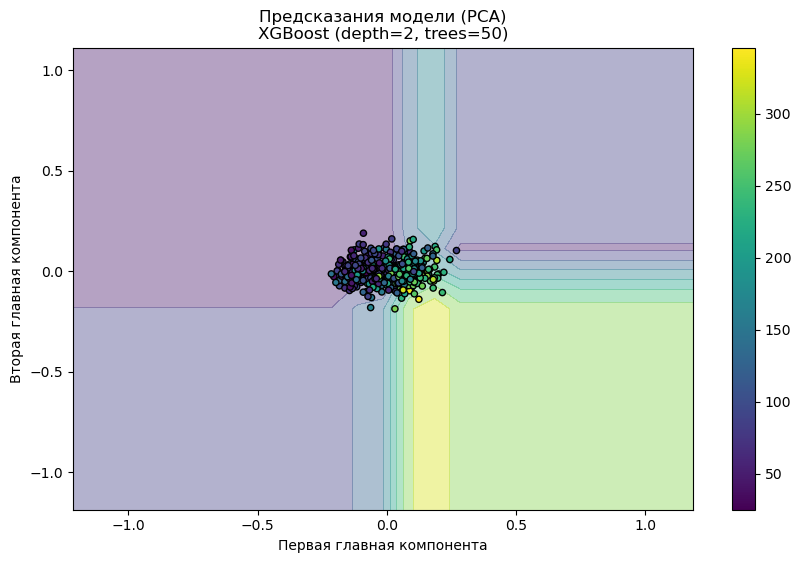

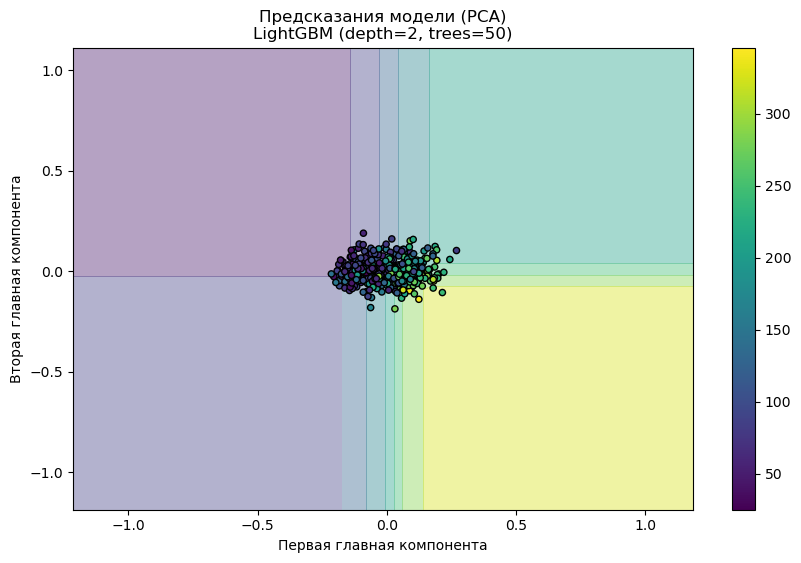

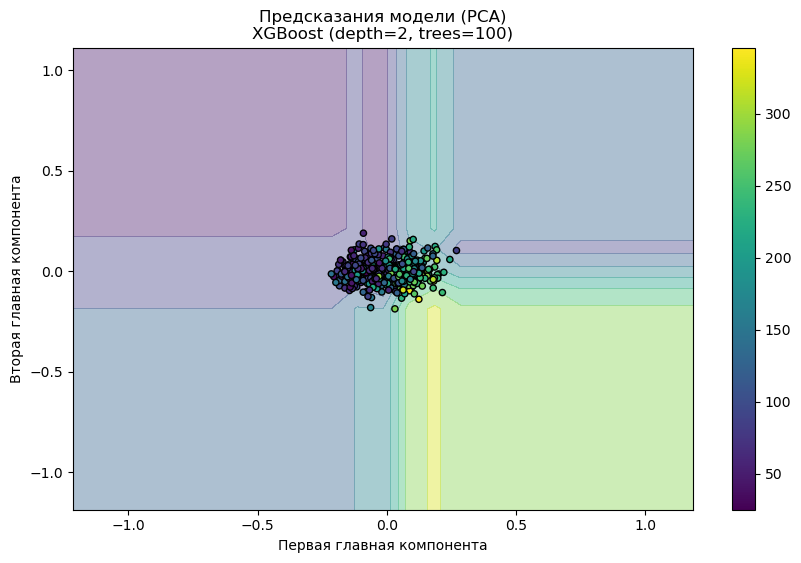

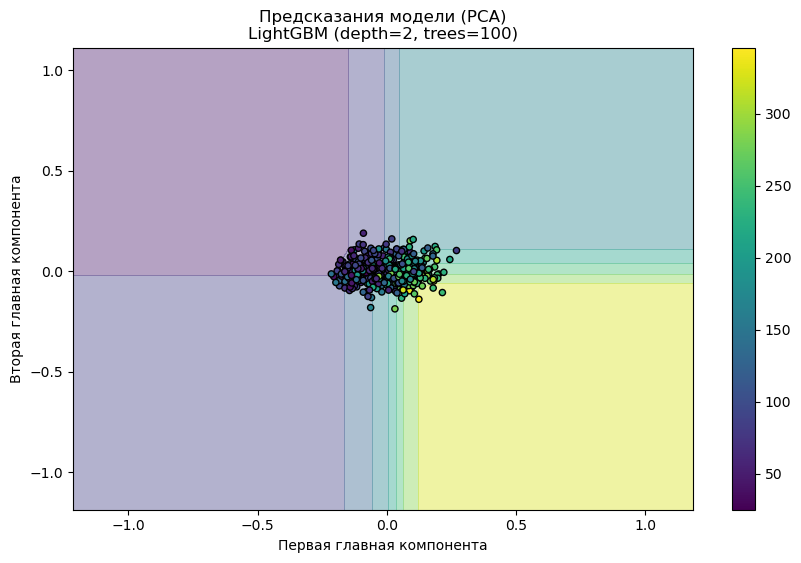

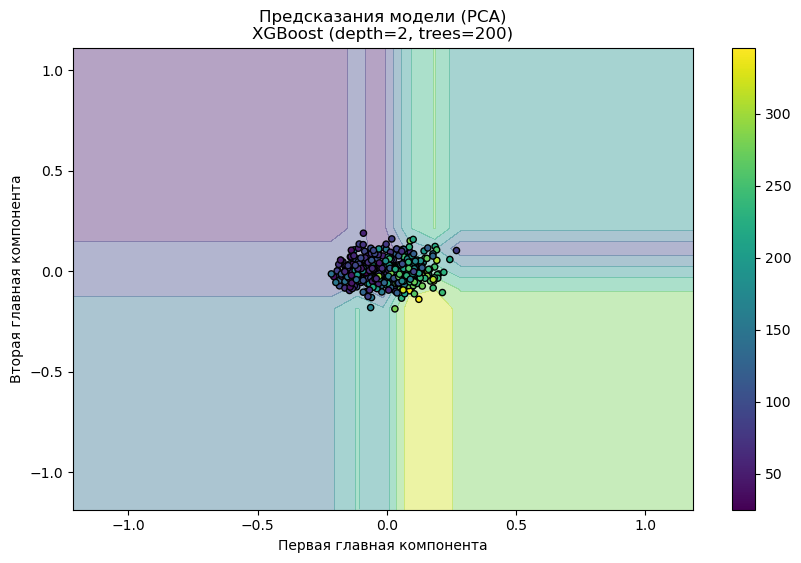

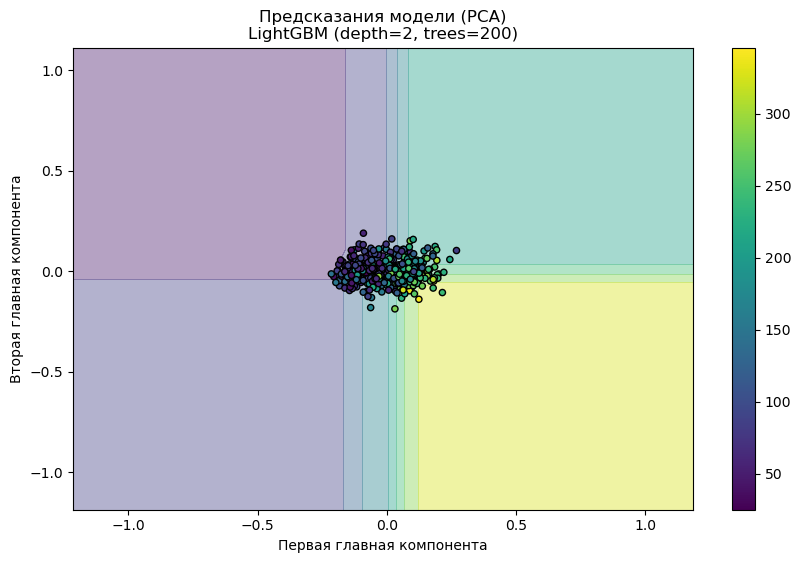

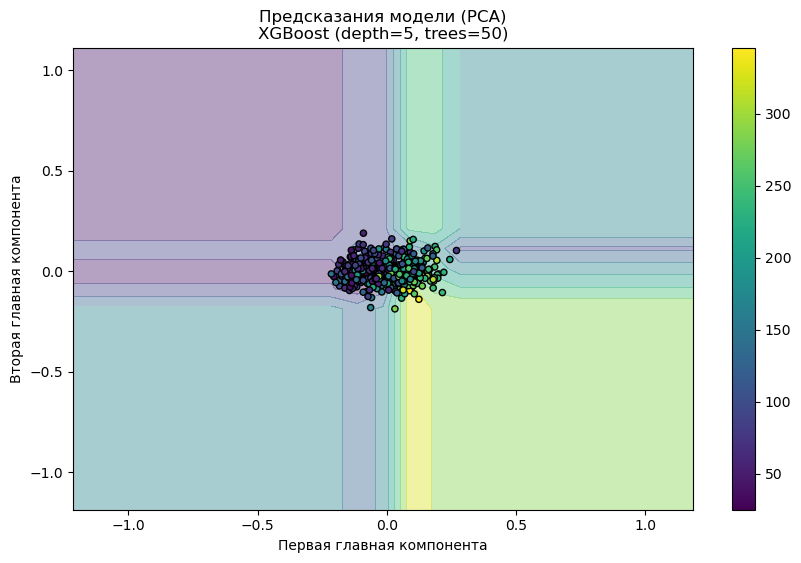

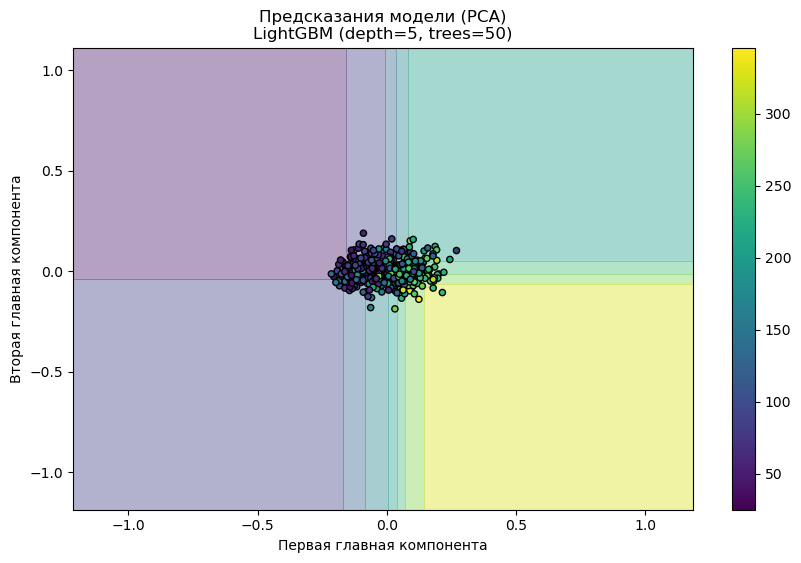

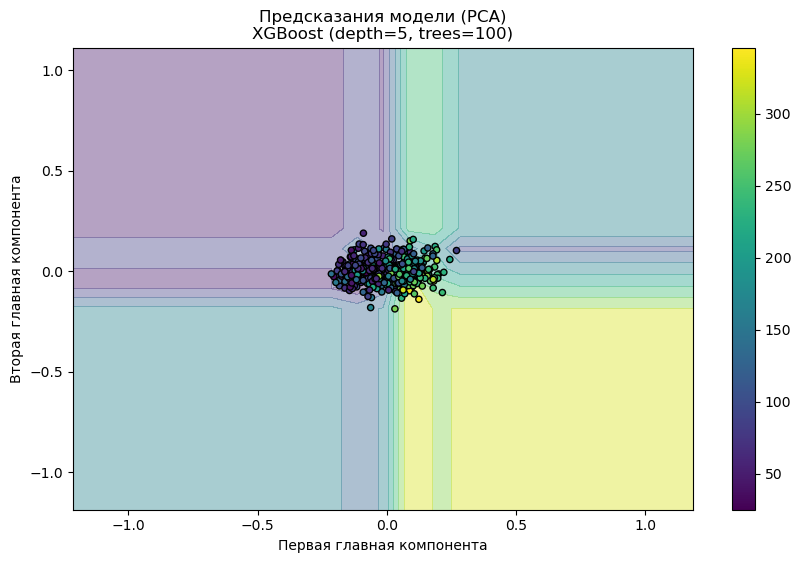

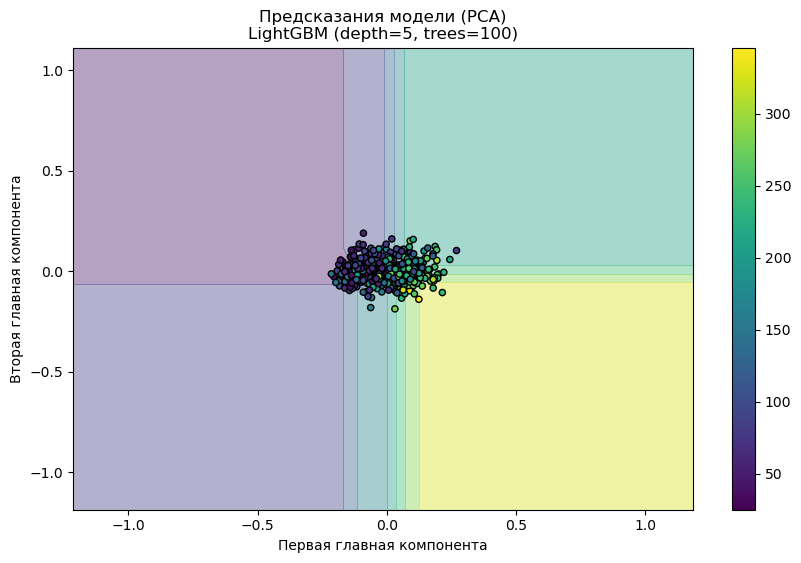

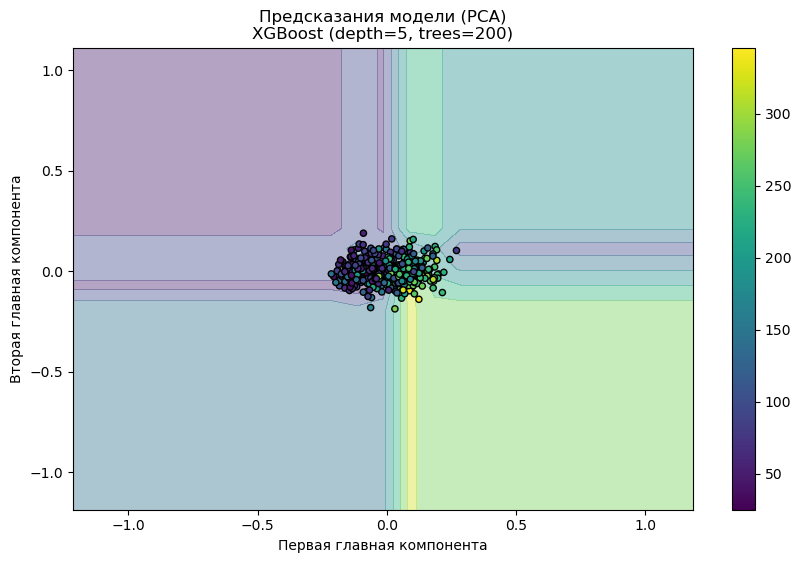

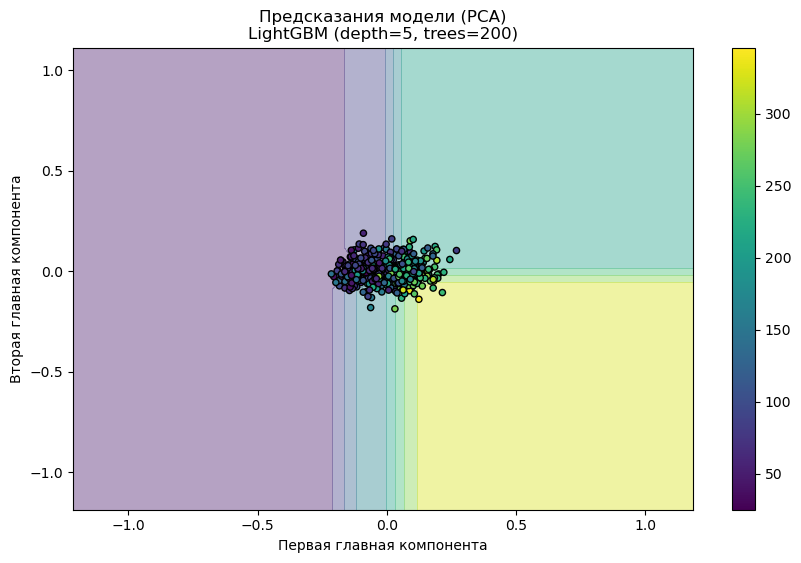

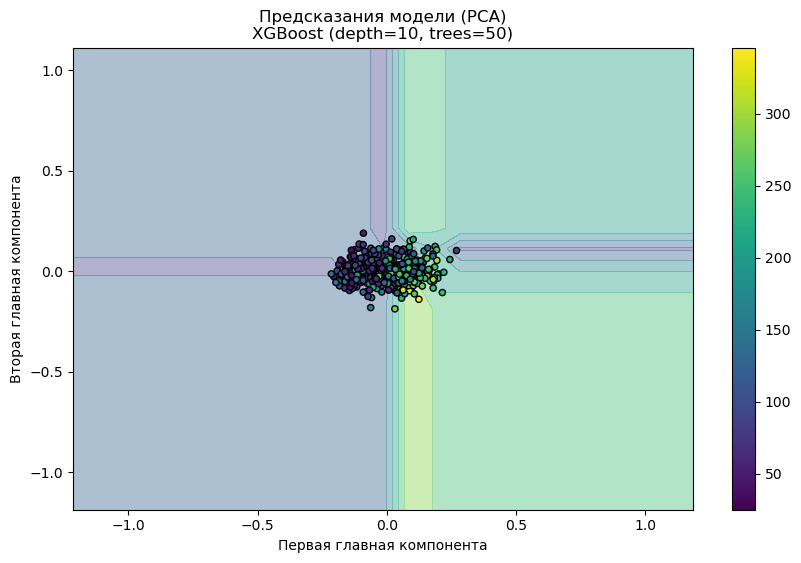

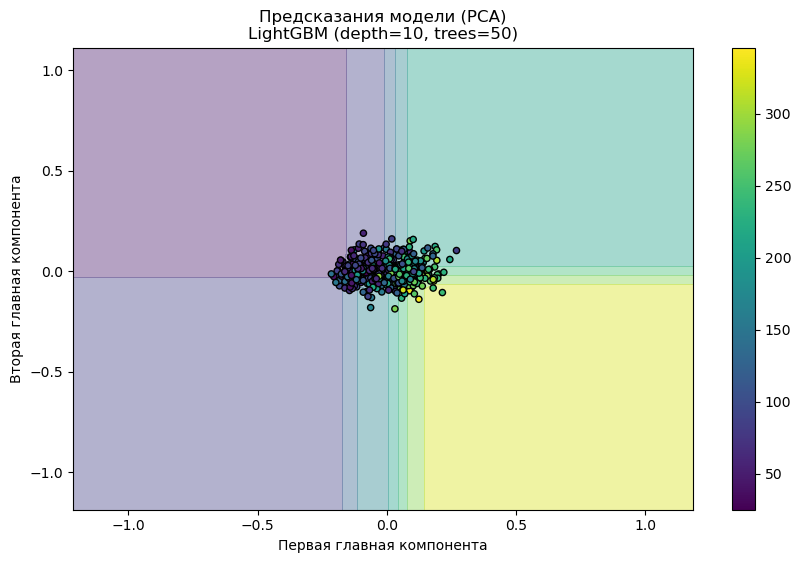

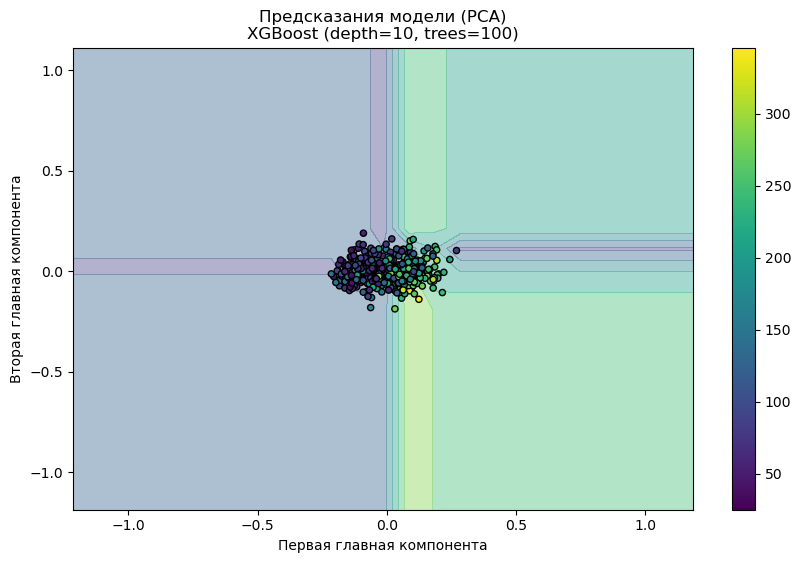

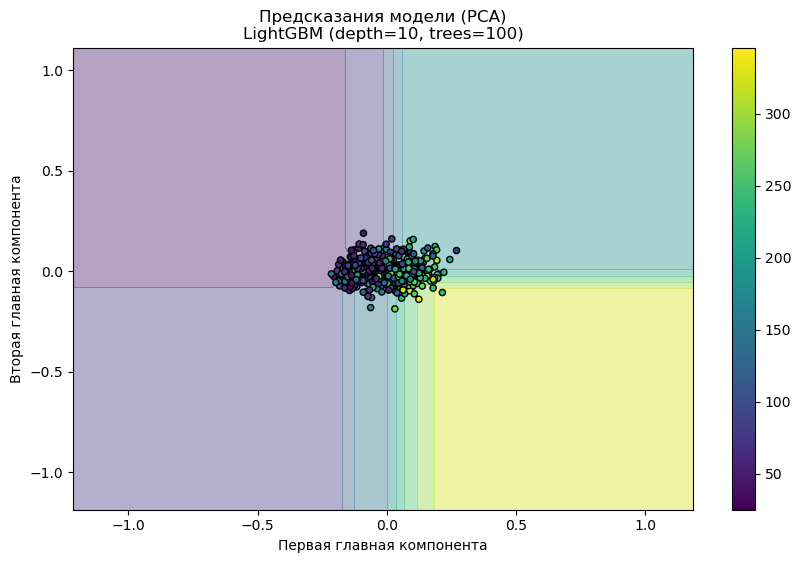

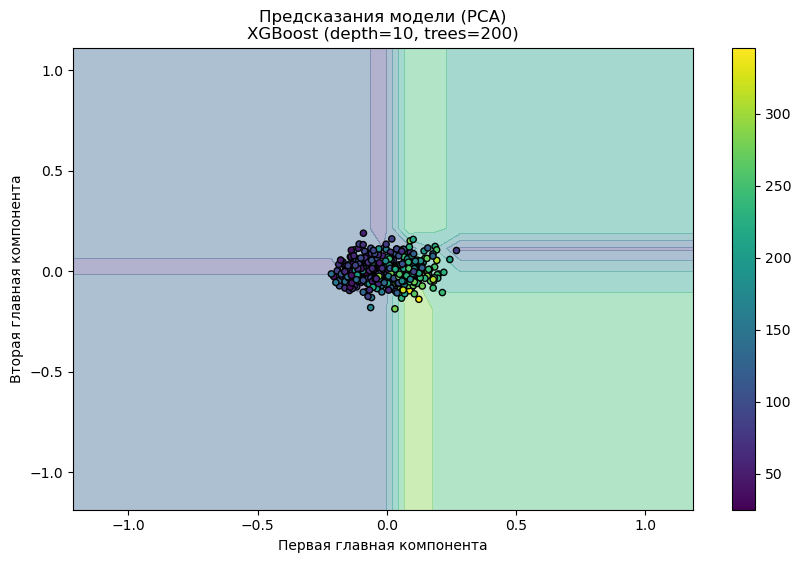

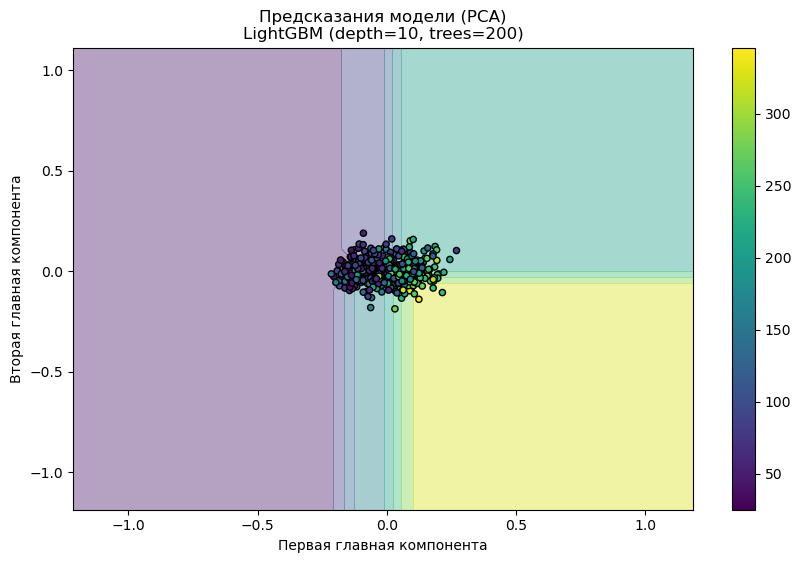

In [69]:
def plot_pca_predictions(model, title):
    x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
    y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))
    
    
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    
    plt.figure(figsize=(10, 6))
    plt.contourf(xx, yy, Z, alpha=0.4)
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=Y, s=20, edgecolor='k')
    plt.title(f'Предсказания модели (PCA)\n{title}')
    plt.xlabel('Первая главная компонента')
    plt.ylabel('Вторая главная компонента')
    plt.colorbar()
    plt.show()


depths = [2, 5, 10]
n_estimators = [50, 100, 200]

for depth in depths:
    for n in n_estimators:
        xgb = XGBRegressor(max_depth=depth, n_estimators=n, random_state=42)
        xgb.fit(X_train_pca, y_train_pca)
        plot_pca_predictions(xgb, f'XGBoost (depth={depth}, trees={n})')
        
        lgbm = LGBMRegressor(max_depth=depth, n_estimators=n, random_state=42)
        lgbm.fit(X_train_pca, y_train_pca)
        plot_pca_predictions(lgbm, f'LightGBM (depth={depth}, trees={n})')

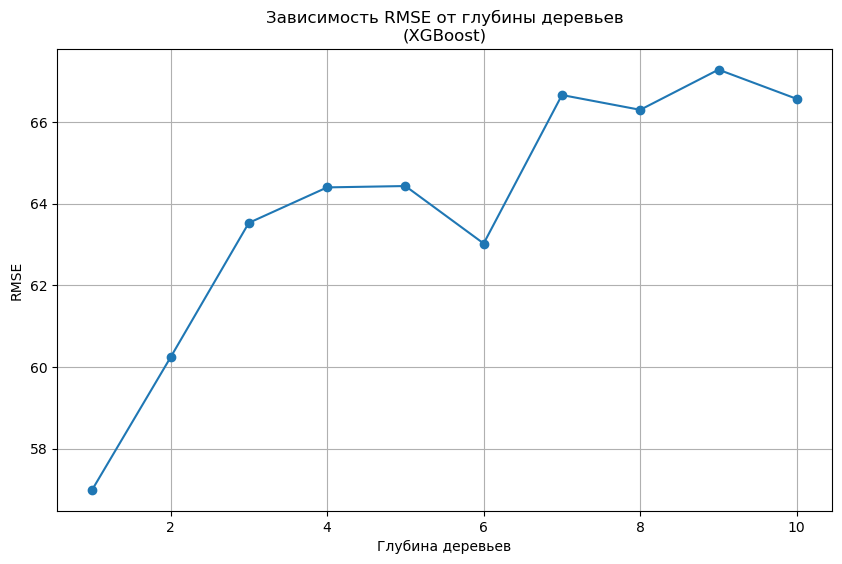

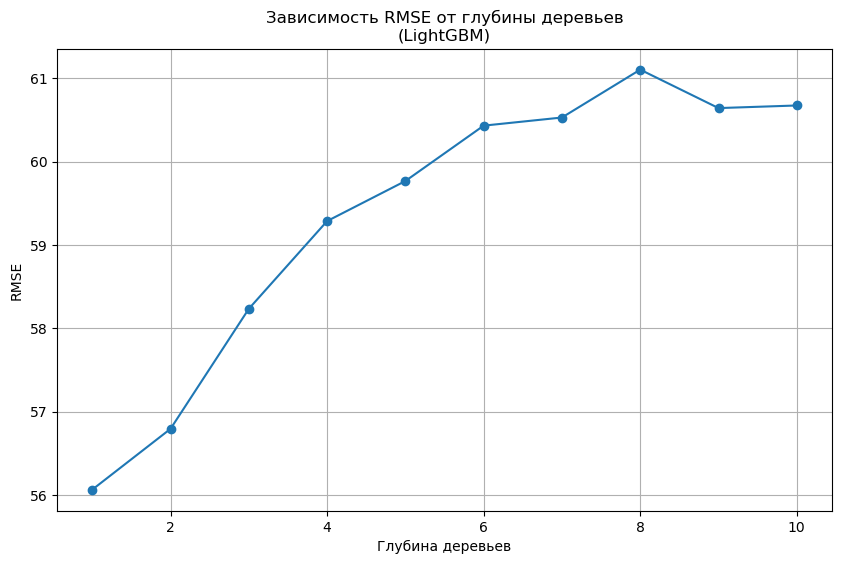

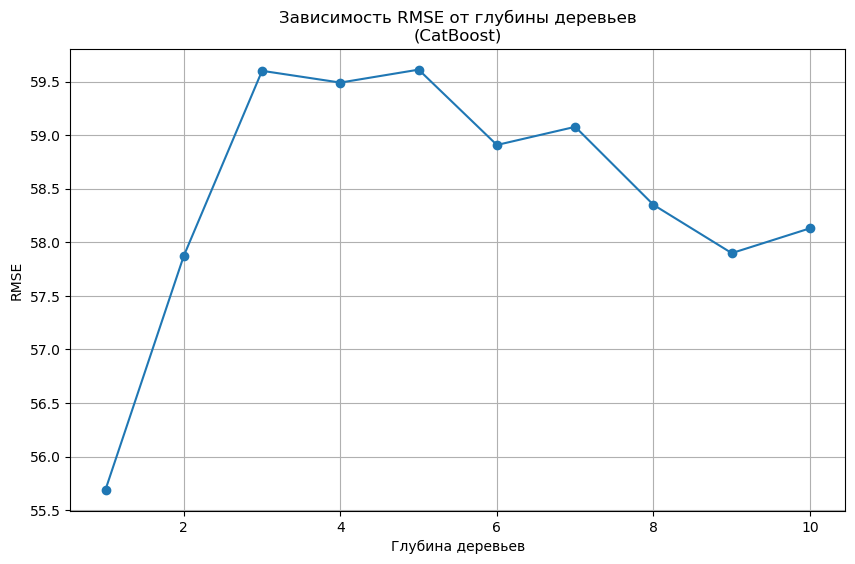

In [70]:
def plot_accuracy_vs_depth(model_type):
    depths = range(1, 11)
    rmse_scores = []
    
    for depth in depths:
        if model_type == 'XGBoost':
            model = XGBRegressor(max_depth=depth, random_state=42)
        elif model_type == 'LightGBM':
            model = LGBMRegressor(max_depth=depth, random_state=42)
        elif model_type == 'CatBoost':
            model = CatBoostRegressor(depth=depth, verbose=0, random_state=42)
        
        scores = cross_val_score(model, X, Y, 
                               scoring='neg_root_mean_squared_error',
                               cv=5)
        rmse_scores.append(-scores.mean())
    
    plt.figure(figsize=(10, 6))
    plt.plot(depths, rmse_scores, marker='o')
    plt.title(f'Зависимость RMSE от глубины деревьев\n({model_type})')
    plt.xlabel('Глубина деревьев')
    plt.ylabel('RMSE')
    plt.grid(True)
    plt.show()

for model in ['XGBoost', 'LightGBM', 'CatBoost']:
    plot_accuracy_vs_depth(model)